#Overview
1. L2 Norm and loading datasets
2. Modifying FF class
3. Use more complex models to reduce bias
4. Demonstrate overfitting for very large models
5. Use L2 regularization for preventing overfitting
6. Use Noise on training data to prevent overfitting
7. Use Early Stopping on training data to prevent overfitting

#Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.colors
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

#import tqdm
from tqdm import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris

from numpy.linalg import norm

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [3]:
np.random.seed(0)

#Generate Data

In [4]:
iris = load_iris()
data = iris.data[:, :2]   #take only first 2 features
labels = iris.target

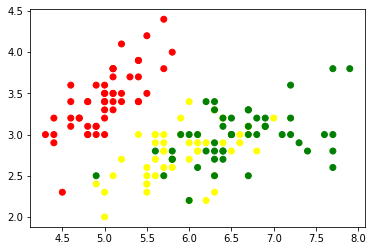

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)   #c -> group colors according to labels

In [6]:
print("Data Shape =  ", data.shape)
print("Labels Shape = ", labels.shape)

Data Shape =   (150, 2)
Labels Shape =  (150,)


#Multi-class Classification

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0, test_size=0.2)
print(X_train.shape, X_val.shape)

(120, 2) (30, 2)


In [10]:
enc = OneHotEncoder()
# 0->(1,0,0,0) ; 1->(0,1,0,0) ; 2->(0,0,1,0) ; 3->(0,0,0,1)
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(Y_OH_train.shape, Y_OH_val.shape)

(120, 3) (30, 3)


#FeedForward Class

In [92]:
# num_hidden hidden layers; 2 inputs ; 3 output classifications

class FFNetwork:

  def __init__(self, num_hidden=2, init_method='xavier', activation_function='sigmoid', leaky_slope=0.1):
    
    self.params = {}
    self.num_layers = 2
    self.layer_sizes = [2, num_hidden, 3]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope

    np.random.seed(0)

    if init_method == "random":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])

    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]) * np.sqrt(1/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])

    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i]) * np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])

    elif init_method == "zeros":
      for i in range(1,self.num_layers+1):
        self.params["W"+str(i)] = np.zeros((self.layer_sizes[i-1],self.layer_sizes[i]))
        self.params["B"+str(i)] = np.zeros((1,self.layer_sizes[i]))

    self.gradients = {}
    self.update_params = {}
    self.prev_update_params = {}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)] = 0
      self.update_params["v_b"+str(i)] = 0
      self.update_params["m_w"+str(i)] = 0
      self.update_params["m_b"+str(i)] = 0
      self.prev_update_params["v_w"+str(i)] = 0
      self.prev_update_params["v_b"+str(i)] = 0

  def forward_activation(self, X):
    if self.activation_function == "sigmoid":
      return 1.0 / (1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0, X)
    elif self.activation_function == "leaky_relu":
      return np.maximum(self.leaky_slope*X, X)

  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X)
    elif self.activation_function == "tanh":
      return (1 - np.square(X))
    elif self.activation_function == "relu":
      return 1.0 * (X>0)
    elif self.activation_function == "leaky_relu":
      d = np.zeros_like(X)
      d[X<=0] = self.leaky_slope
      d[X>0] = 1.0
      return d

  def get_accuracy(self):
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train,Y_train)
    accuracy_val = accuracy_score(Y_pred_val,Y_val)
    return accuracy_train, accuracy_val


  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
 
  def forward_pass(self, X, params=None):
    if params is None:
      params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"]         #A1 dimensions -> (N,2) * (2,2) + (N*1,2) -> (N,2)
    self.H1 = self.forward_activation(self.A1)                             #H1 dimensions -> (N,2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]   #A2 dimensions -> (N,2) * (2,4) + (N*1,4) -> (N,4)
    self.H2 = self.softmax(self.A2)                             #H2 dimensions -> (N,4)
    return self.H2


  def grad(self, X, Y, params=None):
    if params is None:
      params = self.params
    
    self.forward_pass(X, params)
    m = X.shape[0]

    self.gradients["dA2"] = self.H2 - Y                                                             #dA2 dimensions -> (N,4)

    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])                             #dW2 dimensions -> (2,N) * (N,4) -> (2,4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1)                    #dB2 dimensions -> sum(N,4) -> (1,4)

    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)                        #dH1 dimensions -> (N,4) * (4,2) -> (N,2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))    #dA1 dimensions -> (N,2) .* (N,2) -> (N,2)

    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])                                   #dW1 dimensions -> (2,N) * (N,2) -> (2,2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1)                    #dB1 dimensions -> sum(N,2) -> (1,2)


  def fit(self, X, Y, epochs=1, l2_norm=False, lambda_val=0.8, display_loss=False, eta=1):

    train_accuracies = []
    val_accuracies = []

    if display_loss:
      loss = []
      weight_mag = []

    #tqdm_notebook gives a progress bar to show how much of the for loop has completed)
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):  
      m = X.shape[0]

      self.grad(X,Y)
      for i in range(1,self.num_layers+1):
        if l2_norm:
          self.params["W"+str(i)] -= (eta * lambda_val)/m * self.gradients["dW"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
        else:
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)] / m)
        self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)] / m)

      train_accuracy, val_accuracy = self.get_accuracy()
      train_accuracies.append(train_accuracy)
      val_accuracies.append(val_accuracy)

      if display_loss:
        Y_pred = self.predict(X)
        loss.append(log_loss(np.argmax(Y, axis=1), Y_pred))
        weight_mag.append((norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"])))
    
    plt.plot(train_accuracies, label="Train accuracy")
    plt.plot(val_accuracies, label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    if display_loss:
      fig, ax1 = plt.subplots()
      color = 'tab:red'
      ax1.set_xlabel('Epochs')
      ax1.set_ylabel('Log Loss', color=color)
      ax1.plot(loss, '-o', color=color)
      ax1.tick_params(axis='y', labelcolor=color)
      ax2 = ax1.twinx()
      color = 'tab:blue'
      ax2.set_ylabel('Weight Magnitude', color=color)
      ax2.plot(weight_mag, '-*', color=color)
      ax2.tick_params(axis='y', labelcolor=color)
      fig.tight_layout()
      plt.show()

  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [72]:
def print_accuracy():

  Y_pred_train = model.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train,1)

  Y_pred_val = model.predict(X_val)
  Y_pred_val = np.argmax(Y_pred_val,1)

  accuracy_train = accuracy_score(Y_pred_train,Y_train)
  accuracy_val = accuracy_score(Y_pred_val,Y_val)

  print("Training Accuracy", round(accuracy_train, 4))
  print("Validation Accuracy", round(accuracy_val, 4))

  if False:
    plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.2))
    plt.show()


#Testing the Code

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?epoch/s]

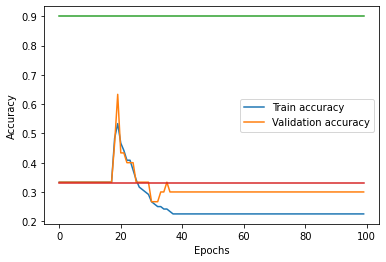

Training Accuracy 0.225
Validation Accuracy 0.3


In [73]:
model = FFNetwork(num_hidden=1)
model.fit(X_train, Y_OH_train, epochs=100, l2_norm=False, eta=0.5, display_loss=False)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?epoch/s]

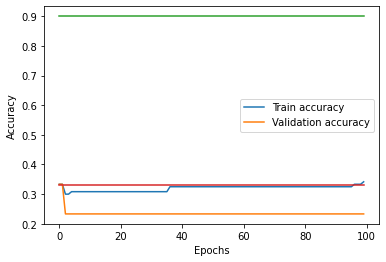

Training Accuracy 0.3417
Validation Accuracy 0.2333


In [74]:
model = FFNetwork(num_hidden=2)
model.fit(X_train, Y_OH_train, epochs=100, l2_norm=False, eta=1, display_loss=False)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/400 [00:00<?, ?epoch/s]

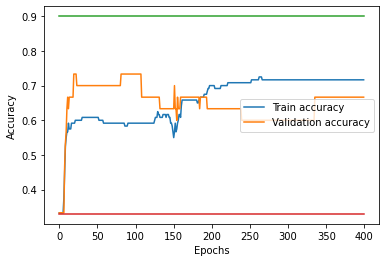

Training Accuracy 0.7167
Validation Accuracy 0.6667


In [75]:
model = FFNetwork(num_hidden=4)
model.fit(X_train, Y_OH_train, epochs=400, l2_norm=False, eta=0.25, display_loss=False)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?epoch/s]

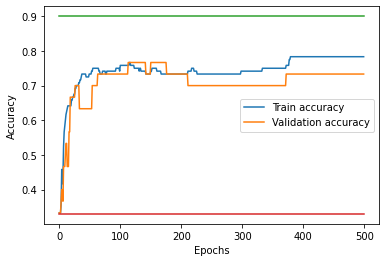

Training Accuracy 0.7833
Validation Accuracy 0.7333


In [76]:
model = FFNetwork(num_hidden=8)
model.fit(X_train, Y_OH_train, l2_norm=False, epochs=500, eta=0.2, display_loss=False)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/500 [00:00<?, ?epoch/s]

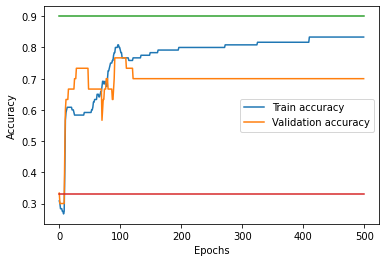

Training Accuracy 0.8333
Validation Accuracy 0.7


In [77]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, Y_OH_train, epochs=500, l2_norm=False, eta=0.2, display_loss=False)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epoch/s]

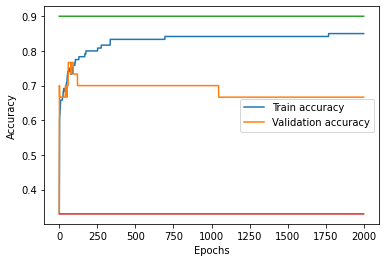

Training Accuracy 0.85
Validation Accuracy 0.6667


In [78]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, l2_norm=False, eta=0.1, display_loss=False)
print_accuracy()

#Adding L2 Regularization (Not Working Properly)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epoch/s]

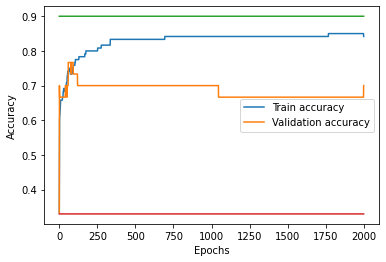

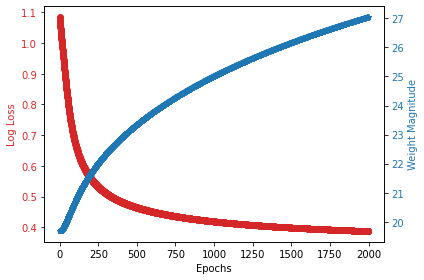

Training Accuracy 0.8417
Validation Accuracy 0.7


In [79]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=0.1, display_loss=True)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epoch/s]

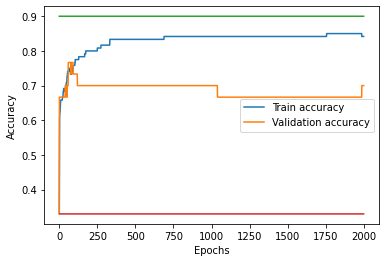

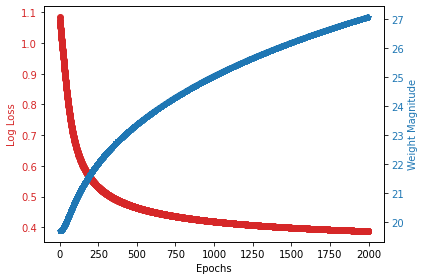

Training Accuracy 0.8417
Validation Accuracy 0.7


In [80]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=1, display_loss=True)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epoch/s]

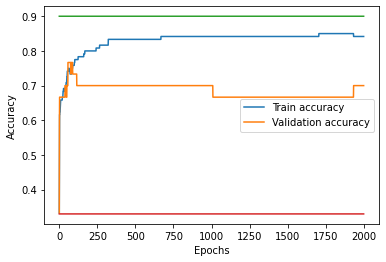

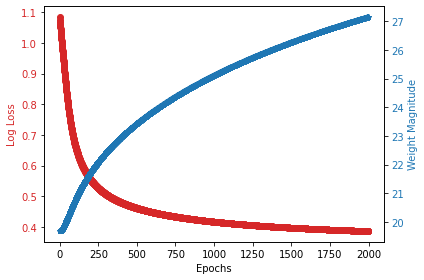

Training Accuracy 0.8417
Validation Accuracy 0.7


In [81]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epoch/s]

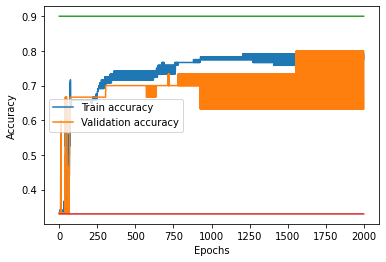

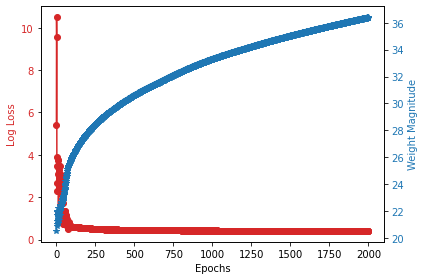

Training Accuracy 0.775
Validation Accuracy 0.6333


In [94]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, eta=0.1, l2_norm=True, lambda_val=10, display_loss=True)
print_accuracy()

#Add Noise to Training Data Set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:122: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2000 [00:00<?, ?epoch/s]

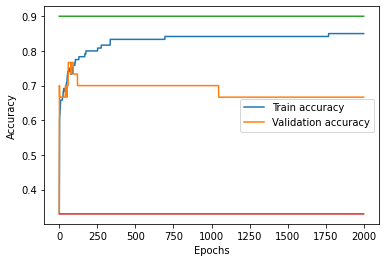

Training Accuracy 0.85
Validation Accuracy 0.6667


In [85]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, eta=0.1, l2_norm=False, display_loss=False)
print_accuracy()

In [ ]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  X_train_noisy = X_train * (1 - noise_fraction*np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFNetwork(num_hidden=64)
  model.fit(X_train_noisy, Y_OH_train, epochs=2000, eta=0.1, l2_norm=False, display_loss=False)
  print_accuracy()

#Early Stopping

In [ ]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, Y_OH_train, epochs=500, eta=0.2, l2_norm=False, display_loss=False)
print_accuracy()

In [ ]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, Y_OH_train, epochs=100, eta=0.2, l2_norm=False, display_loss=False)
print_accuracy()